# Quantum Computing

## 3. Robustness

**Frank C Langbein**

$\def\ket#1{|#1\rangle} \def\bra#1{\langle#1|}$

In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Decoherence

* Real quantum devices must deal with **decoherence**
  * Loss of coherence / quantum information due to **interactions with the environment**
  * Also, **fabrication unceratinties** - we cannot reliably build a device atom by atom
  * Note, steering a quantum device to perform a desired operation (rather than its natural evolution), always requries interaction with the environment
    * So also **noise and uncertainty in controls**
    * Perfectly isolated systems can remain coherent for a long time, but likely do not compute anything interesting

# Simulating a Coherent Quantum System

* Follows the Schroedinger equation
  $$i\hbar \frac{\partial}{\partial t} \ket{\Psi} = H \ket{\Psi}$$
  * $H$ here is the Hamiltonian of the system describing its dynamics
  * The propagator (for constant Hamiltonian, otherwise matrix exponential is more complex)
    $$U(t) = \text{expm}\left(-iH \frac{t}{\hbar} \right)$$
    gives the "gate" realised at time $t$, $\ket{\Psi(t)} = U \ket{\Psi(0)}$
    
 * E.g. $H = 2\pi 0.1 X$ (note, $X$ here is the Pauli X operator, but represent a time-dependent rotation)

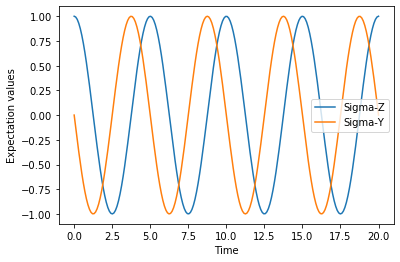

In [2]:
H = 2.0 * np.pi * 0.1 * sigmax()
psi0 = ket("0")
times = np.linspace(0.0, 20.0, 200)
# Simulate and produce result.expect arrays of measuremnet operators Z and Y
result1 = mesolve (H, psi0, times, [], [sigmaz(), sigmay()])
# Plot
fig, ax = plt.subplots()
ax.plot(result1.times, result1.expect[0]); ax.plot(result1.times, result1.expect[1])
ax.set_xlabel('Time'); ax.set_ylabel('Expectation values'); ax.legend(("Sigma-Z","Sigma-Y"));

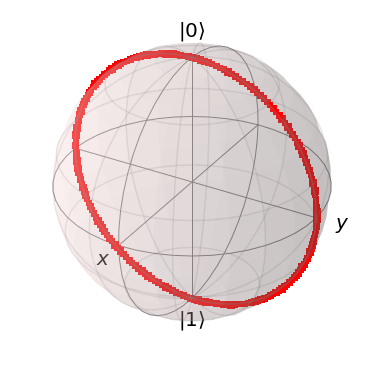

In [3]:
b = Bloch(); b.point_color = ['r']; b.point_marker = ['s']; b.clear()
for l in range(len(result1.expect[0])):
  b.add_points([0,result1.expect[1][l],result1.expect[0][l]])
b.show()

# Pure vs Mixed States

* We have only studied **pure states** $\ket{\Psi}$, i.e. $\|\Psi\|^2=\langle\Psi|\Psi\rangle = 1$
* Decoherence causes the state to become a **mixed state**, described by a **density matrix**
  $$\rho = \sum_k p_k \ket{\Psi_k}\bra{\Psi_k}$$
  where the $\ket{\Psi_k}$ are pure states and $p_k$ is the probability of the system being in $\ket{\Psi_k}$
  * Can be thought of as an ensemble state (mixture state in a statistical ensemble of independent systems)
  * Their Bloch vector has a length $< 1$
  * Some of the information of the system is in an inaccessible (Hilbert) space $K$ of the total (Hilbert) space $H \otimes K$
* Pure sate: $\text{tr}(\rho^2) = 1$; mixed state $\text{tr}(\rho^2) < 1$


# Lindblad Master Equation

* To describe non-unitary evolution, we need to generalise the Schroedinger equation:
    $$\rho(0) = \sum p_k \ket{\Psi_k}\bra{\Psi_k}; U_t\ket{\Psi_k} = \text{expm}(-iH t/\hbar)\ket{\Psi_k}$$
    $$\rho(t) = \sum p_k U_t \ket{\Psi_k}\bra{\Psi_k}U_t^\dagger = U_t \rho U_t^\dagger$$
* This gives the Liouville-von Neumann equation
    $$\frac{d}{dt} \rho(t) = -\frac{i}{\hbar} [H,\rho]$$
* The inaccessible Hilbert space $K$ is also in $H$ here. As we do not know it, we replace it with the most general trace-preserving and completely positive form of that part of the evolution
* This gives  the Lindblad equation
    $$\frac{d}{dt}\rho(t) = -\frac{i}{\hbar}[H(t),\rho(t)] 
      + \sum_n \frac{1}{2} \left(2C_n\rho(t)C_n^\dagger - \rho(t)C_n^\dagger C_n - C_n^\dagger C_n\rho(t)\right)$$
  * where $C_n = \sqrt{\gamma_n} A_n$ are the collapse operators, $A_n$ are the operators coupling the environment to the system, $\gamma_n$ are the corresponding rates

# Energy Relaxation ($T_1$)

* An excited state decays toward the ground state
  * $T_1$ is the time constant indicating the speed of this 

* E.g. add $\sqrt{0.1} X$ as relaxation process
  * Dissipation of energy of the qubit to its environment at rate $0.1$ coupled via $X$
    

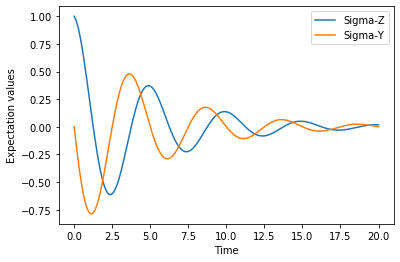

In [4]:
# Simulate now with energy relaxation process
result2 = mesolve (H, psi0, times, [np.sqrt(0.1) * sigmax()], [sigmaz(), sigmay()])
# Plot
fig, ax = plt.subplots()
ax.plot(result2.times, result2.expect[0]); ax.plot(result2.times, result2.expect[1])
ax.set_xlabel('Time'); ax.set_ylabel('Expectation values'); ax.legend(("Sigma-Z","Sigma-Y"));

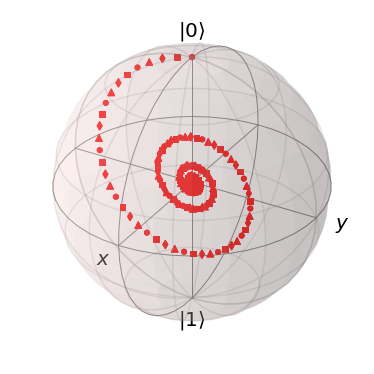

In [5]:
b = Bloch(); b.point_color = ['r']; b.point_maker = ['s']; b.clear()
for l in range(len(result2.expect[0])):
  b.add_points([0,result2.expect[1][l],result2.expect[0][l]])
b.show()

# Dephasing ($T_2$)

* Loss of coherence between states, rather than loss of energy
  * Affects superposition of states
  * $T_2$ is the time constant indicating speed of this effect

* [Hahn Echo with Decay (Wikipedia)](GWM_HahnEchoDecay.gif)

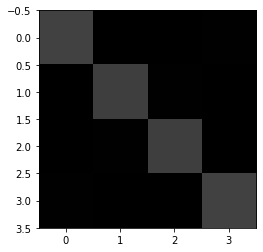

In [6]:
# Simulate two XX-coupled qubits with dephasing and energy relaxation
psi1 = (ket("00")+ket("11"))/np.sqrt(2)
H1 = tensor(qeye(2),sigmax()) * tensor(sigmax(),qeye(2)) + tensor(qeye(2),sigmay()) * tensor(sigmay(),qeye(2))
result3 = mesolve (H1, psi1, times, [np.sqrt(0.1)*tensor(qeye(2),sigmax()),np.sqrt(0.1)*tensor(qeye(2),sigmaz())], [])
# Plot
fig = plt.figure(); ims = [];
for l in range(len(result3.states)):
    ims.append([plt.imshow(np.abs(result3.states[l].full()),cmap='gray',vmin=0,vmax=1)]);
anim = animation.ArtistAnimation(fig, ims, interval=50, blit=True);
HTML(anim.to_html5_video())

# Repetition Code

* Simplest example of a **quantum error correction code**

* Encode a 1 bit message by copying it several times (say 3)
  * 00 encodes to 000000 and 11 encodes to 111111
* Store 000000 or 111111 for some time and assume an error occurs
  * Assume each bit may flip with probability $p < 1/2$, independently
  * Original message is the value indicated by a majority of the bits 
    $$\text{maj}(a,b,c)=ab\oplus bc\oplus ca$$
  * This only works for a single error
    * Reduces the failure probability as the probability of more than one error is
      $$3p^2(1-p) + p^3 < p, \text{ if } p < 1/2$$
    * For $p=0.1$, failure after encoding is less than $0.028$


# Quantum Repetition Code - Bit-Flips

* Repetition code is classical error correction
  * 3-qubit bit-flip code example to encode, decode and detect errors

* Encode 1-qubit message: $\ket{\Psi} = a\ket{0}+b\ket{1}$ in 3-qubit bit-flip code:
  $$a\ket{000} + b\ket{111}$$
  * Note, we cannot copy the state, as in the classical case, but can still create an entangled state
    
* Decode the message (after some time where decoherence may have caused an error):
  * Reversible majority voter to decode the bit-flip code
  
* [bit-flip encoder/decoder](quirk.html#circuit={"cols":[["~87lj"],["Bloch"],["Density"],["•","X"],["•",1,"X"],["Density3"],[],[],["…","…","…"],["Amps3"],[],["…","…","…"],["•",1,"X"],["•","X"],["X","•","•"],["Density"],["~f7c0"]],"gates":[{"id":"~87lj","name":"message","circuit":{"cols":[["e^-iYt"],["X^t"]]}},{"id":"~f7c0","name":"received","matrix":"{{1,0},{0,1}}"}]})

# Phase-Flip Code

* Error operators arising from independent decoherence processes on each qubit can be written as linear combinations of $I$, $X$, $Y=−iZX$, $Z$ (this is not trivial to show; Shor 1995)
* As quantum mechanics is linear, only bit-flip $X$ and phase-flip $Z$ errors must be corrected
  * Correcting a discrete set of errors means the sums of those errors, and hence the continuum of errors, are corrected as well [Shor 1995]
* Bit flip code can only correct bit-flip errors, though
  * A phase-flip changes the message to $a\ket{000} - b\ket{111}$
  * But this is an encoding of $a\ket{0}-b\ket{1}$, which is a valid code, too
  * So the bit-flip code is not sufficient to correct realistic errors

* [phase-flip encoder/decoder](quirk.html#circuit={"cols":[["~87lj"],["Bloch"],["Density"],["•","X"],["•",1,"X"],["H","H","H"],["Density3"],[],[],["…","…","…"],["Amps3"],[],["…","…","…"],["H","H","H"],["•",1,"X"],["•","X"],["X","•","•"],["Density"],["~f7c0"]],"gates":[{"id":"~87lj","name":"message","circuit":{"cols":[["e^-iYt"],["X^t"]]}},{"id":"~f7c0","name":"received","matrix":"{{1,0},{0,1}}"}]}) (bit-flip encoder in the superposition basis)

# Shor Code

* [phase-flip and bit-flip encoder/decoder](quirk.html#circuit={"cols":[["~87lj"],["Bloch"],["Density"],["•",1,1,"X"],["•",1,1,1,1,1,"X"],["H",1,1,"H",1,1,"H"],["…",1,1,"…",1,1,"…"],["•","X"],["•",1,"X"],[1,1,1,"•","X"],[1,1,1,"•",1,"X"],[1,1,1,1,1,1,"•","X"],[1,1,1,1,1,1,"•",1,"X"],["…","…","…","…","…","…","…","…","…"],["Chance9"],["…","…","…","…","…","…","…","…","…"],["•",1,"X"],["•","X"],["X","•","•"],[1,1,1,"•",1,"X"],[1,1,1,"•","X"],[1,1,1,"X","•","•"],[1,1,1,1,1,1,"•",1,"X"],[1,1,1,1,1,1,"•","X"],[1,1,1,1,1,1,"X","•","•"],["…",1,1,"…",1,1,"…"],["H",1,1,"H",1,1,"H"],["•",1,1,1,1,1,"X"],["•",1,1,"X"],["X",1,1,"•",1,1,"•"],["Density"],["~f7c0"]],"gates":[{"id":"~87lj","name":"message","circuit":{"cols":[["e^-iYt"],["X^t"]]}},{"id":"~f7c0","name":"received","matrix":"{{1,0},{0,1}}"}]}) (combine both circuits; Shor code)

* Note there are more recent codes than this (see **stabiliser codes**, **topological codes**)